# Multiclass Peak Detection in fDOM

This file combines all of the fDOM detection scripts into a singular classifier, that detects all peak types. On top of this, it also leverages the augmented data created previously.

## Structure

The core structure of the project is to have all individual classifiers running, and then when one detects a peak, it alerts the overall classifier "manager", which then takes note of the peak that a classifier has detected as an anomaly peak.


In [1]:
# Imports
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sn
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
)
import pandas as pd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import pickle
import progressbar

import Tools.data_processing as dp
import Tools.data_movement as dm
from Tools.get_all_cands import get_all_cands_fDOM, get_all_truths_fDOM

# import classifiers
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_PLP import (
    fDOM_PLP_Classifier,
)
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_FPT import (
    fDOM_FPT_Classifier,
)
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_FSK import (
    fDOM_FSK_Classifier,
)
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_PP import (
    fDOM_PP_Classifier,
)
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_SKP import (
    fDOM_SKP_Classifier,
)

# disable warnings
def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn


## Training parameters and helper functions


In [2]:
ITERATIONS = 4000
NUM_SPLITS = 5
AUGMENT_DATA_BEGIN_TIMESTAMP = 2459096.9583333335
USE_AUGMENTED_DATA = True
CLASS_BALANCED_ONLY = True

# for confusion matrix
DATA_LABELS = ["PLP", "SKP", "PP", "FPT", "FSK", "NAP"]

# Useful functions
def get_prediction(plp_pred, skp_pred, pp_pred, fpt_pred, fsk_pred):
    """
    take the top level prediction based on peak precendence
    """
    if skp_pred == "SKP":
        return skp_pred

    elif pp_pred == "PP":
        return pp_pred

    elif plp_pred == "PLP":
        return plp_pred

    elif fpt_pred == "FPT":
        return fpt_pred

    elif fsk_pred == "FSK":
        return fsk_pred

    else:
        return "NAP"


In [3]:
# Filenames
fdom_raw_data = "Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
stage_raw_data = "Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = "Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"

fdom_labeled = "Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"

fdom_raw_augmented = "Data/augmented_data/fdom/unlabeled/unlabeled_fdom.csv"
fdom_labeled_augmented = "Data/augmented_data/fdom/labeled/labeled_fdom_peaks.csv"

turb_augmented_raw_data = "Data/augmented_data/fdom/unlabeled/unlabeled_turb.csv"

stage_augmented_data_fn = "Data/augmented_data/fdom/unlabeled/unlabeled_stage.csv"

# to get fsk/fpt peaks in augmented data
fdom_fpt_lookup_path = "Data/augmented_data/fdom/fpt_lookup.csv"
fdom_fsk_lookup_path = "Data/augmented_data/fdom/fsk_lookup.csv"


In [4]:
# Load Data
fDOM_data = dm.read_in_preprocessed_timeseries(fdom_raw_data)
stage_data = dm.read_in_preprocessed_timeseries(stage_raw_data)
turb_data = dm.read_in_preprocessed_timeseries(turb_raw_data)
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

augmented_fdom_data = np.array(dm.read_in_timeseries(fdom_raw_augmented, True))
augmented_turb_data = np.array(dm.read_in_timeseries(turb_augmented_raw_data, True))
augmented_stage_data = np.array(dm.read_in_timeseries(stage_augmented_data_fn, True))


## Get Candidates and truths


In [5]:
# get candidates from raw data
cands = get_all_cands_fDOM(
    fdom_raw_data,
    fdom_labeled,
)

# get truths from raw data
truths = get_all_truths_fDOM(fdom_labeled)

# assert they are the same size
assert truths.shape == cands.shape

print(f"Total number of original data candidates: {cands.shape[0]}")


Total number of original data candidates: 1636


### Augmented Data

Make sure that `USE_AUGMENTED_DATA` == `True`, for this data to take effect


In [6]:
if USE_AUGMENTED_DATA:
    # get candidates from augmented data
    cands_augmented = get_all_cands_fDOM(
        fdom_raw_augmented,
        fdom_labeled_augmented,
        True,
        fdom_fpt_lookup_path,
        fdom_fsk_lookup_path,
    )

    truths_augmented = get_all_truths_fDOM(fdom_labeled_augmented, True)

    # align the missing augmented data (FPT, NFPT, FSK, NFSK, some others)
    truths_augmented = truths_augmented[
        truths_augmented["idx_of_peak"].isin(cands_augmented["idx_of_peak"])
    ]

    assert truths_augmented.shape == cands_augmented.shape

    print(f"Total number of augmented candidates: {cands_augmented.shape[0]}")

    # concatenate two candidates and truths into single list
    cands = pd.concat([cands, cands_augmented])
    truths = pd.concat([truths, truths_augmented])

    # concat augmented raw data to normal raw data, for classifier preprocessing
    turb_data_total = np.concatenate((turb_data, augmented_turb_data))
    fdom_total = np.concatenate((fDOM_data, augmented_fdom_data))
    stage_total = np.concatenate((stage_data, augmented_stage_data))

# if we aren't using augmented data, make sure classifiers have correct data being passed into them for preprocessing
else:
    turb_data_total = turb_data
    fdom_total = fDOM_data
    stage_total = stage_data


Total number of augmented candidates: 3764


## Alternatively, use only augmented data for pure class balanced training/testing


In [7]:
if CLASS_BALANCED_ONLY:
    # get candidates from augmented data
    cands = get_all_cands_fDOM(
        fdom_raw_augmented,
        fdom_labeled_augmented,
        True,
        fdom_fpt_lookup_path,
        fdom_fsk_lookup_path,
    )

    truths = get_all_truths_fDOM(fdom_labeled_augmented, True)

    # align the missing augmented data (FPT, NFPT, FSK, NFSK, some others)
    truths = truths[truths["idx_of_peak"].isin(cands["idx_of_peak"])]

    assert truths.shape == cands.shape

    print(f"Total number of candidates: {cands.shape[0]}")

    turb_data_total = augmented_turb_data
    fdom_total = augmented_fdom_data
    stage_total = augmented_stage_data


Total number of candidates: 3764


In [8]:
# Convert cands and truths into lists
cands = cands.values.tolist()

truths = truths.values.tolist()

print(str(len(cands)) + " candidates in provided data.")


3764 candidates in provided data.


In [9]:
train_cands = cands_augmented.values.tolist()
train_truths = truths_augmented.values.tolist()


## Create Classifiers


In [10]:
plp_classifer = fDOM_PLP_Classifier(
    fdom_total,
    turb_data_total,
    fdom_raw_data,
    fdom_labeled,
    fdom_raw_augmented,
    fdom_labeled_augmented,
)


In [11]:
skp_classifier = fDOM_SKP_Classifier(
    fdom_total, fdom_raw_data, fdom_labeled, fdom_raw_augmented, fdom_labeled_augmented
)


In [12]:
pp_classifier = fDOM_PP_Classifier(
    fdom_total, stage_total, AUGMENT_DATA_BEGIN_TIMESTAMP
)


In [13]:
fpt_classifier = fDOM_FPT_Classifier(fdom_total)


In [14]:
fsk_classifier = fDOM_FSK_Classifier(fdom_total)


## Training Loop


In [15]:
accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

discovered_labels = []

# split data
tss = TimeSeriesSplit(NUM_SPLITS)

overall_start = datetime.datetime.now()

split = 1
divide_by_zero_errs = 0

for train_val_indices, test_indices in tss.split(cands):
    X_train, y_train = [cands[i] for i in train_val_indices], [
        truths[i] for i in train_val_indices
    ]

    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]

    max_fold_metric = 0
    max_result = None

    # print out info for user
    print("\nSplit: ", split)
    split_start = datetime.datetime.now()
    num_pos_test = len(list(filter(lambda x: x[2] != "NAP", y_test)))
    num_pos_train = len(list(filter(lambda x: x[2] != "NAP", y_train)))

    print(f"Num Pos in Test: {num_pos_test}")
    print(f"Num Pos in Train: {num_pos_train}")

    if num_pos_test >= 1 and num_pos_train >= 1:
        # instantiate the progress bar
        pbar = progressbar.ProgressBar(max_value=ITERATIONS)

        # main training loop
        for iteration in range(ITERATIONS):
            params = {}

            # start the iteration for each classifier (resets predictions, generates params)
            params["plp"] = plp_classifer.start_iteration()
            params["skp"] = skp_classifier.start_iteration()
            params["pp"] = pp_classifier.start_iteration()
            params["fpt"] = fpt_classifier.start_iteration()
            params["fsk"] = fsk_classifier.start_iteration()

            # empty predictions array
            train_preds = []

            plp_preds = plp_classifer.classify_samples(X_train)
            # skp_preds = skp_classifier.classify_samples(X_train)
            pp_preds = pp_classifier.classify_samples(X_train)
            # fpt_preds = fpt_classifier.classify_samples(X_train)
            # fsk_preds = fsk_classifier.classify_samples(X_train)
            for i, pred in enumerate(plp_preds):
                # train_pred = get_prediction(
                #     pred[1], skp_preds[i][1], pp_preds[i][1], fpt_preds[i][1], fsk_preds[i][1]
                # )

                # HACK: SINGLE CLASSIFIER TEST SECTION REMOVE IN PROD ENV
                train_pred = pp_preds[i][1]

                train_preds.append(train_pred)

            ######## GET SCORES ########
            bal_acc = balanced_accuracy_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
            )

            acc = accuracy_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
            )

            f1_train = f1_score(
                [row[2] for row in y_train], [row for row in train_preds], average=None
            )

            # print out acc in 10 even splits
            if iteration and iteration % int(ITERATIONS / 10) == 0:
                print("Iteration {} acc: {} ".format(iteration, acc), end="")

            # check acc, if better than max fold, save it
            if acc > max_fold_metric:
                max_fold_metric = acc
                max_result = copy.deepcopy(train_preds)

                # save params of classifiers
                plp_classifer.got_best_result()
                skp_classifier.got_best_result()
                pp_classifier.got_best_results()
                fpt_classifier.got_best_results()
                fsk_classifier.got_best_results()

            # call end of iteration, as we are at the end of an iteration
            # allows individual classifiers to calc results
            plp_classifer.end_of_iteration(y_train)
            # skp_classifier.end_of_iteration(y_train)
            pp_classifier.end_of_iteration(y_train)
            # fpt_classifier.end_of_iteration(y_train)
            # fsk_classifier.end_of_iteration(y_train)

            # TODO make confusion matrix on training data
            

            # update the progressbar
            pbar.update(iteration)

        # perform peak testing
        test_preds = []
        plp_preds = plp_classifer.classify_samples(X_test, True)
        # skp_preds = skp_classifier.classify_samples(X_test, True)
        pp_preds = pp_classifier.classify_samples(X_test, True)
        # fpt_preds = fpt_classifier.classify_samples(X_test, True)
        # fsk_preds = fsk_classifier.classify_samples(X_test, True)

        for i, pred in enumerate(plp_preds):
            # test_pred = get_prediction(
            #     pred[1], skp_preds[i][1], pp_preds[i][1], fpt_preds[i][1], fsk_preds[i][1]
            # )

            test_pred = pp_preds[i][1]

            test_preds.append(test_pred)


        ######## GET SCORES ########
        # get confusion matrix
        cfmx = confusion_matrix(
            [row[2] for row in y_test],
            [row for row in test_preds],
            labels=DATA_LABELS,
        )

        print(cfmx)

        # get acc score
        acc_score = accuracy_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
        )

        bal_acc = balanced_accuracy_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
        )

        f1 = f1_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
            average="weighted",
        )

        precision = precision_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
            average="weighted",
        )

        print(f"\nSplit {split} test Scores: F1: {f1}  BA: {bal_acc}  ACC: {acc_score}")

        accumulated_cfmxs[split] = copy.deepcopy(cfmx)

        accumulated_test_metrics[split] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

        accumulated_test_results[split] = copy.deepcopy(test_preds)

        # save the best params
        accumulated_best_params[split] = {
            "PLP": copy.deepcopy(plp_classifer.best_params),
            "SKP": copy.deepcopy(skp_classifier.best_params),
            "PP": copy.deepcopy(pp_classifier.best_params),
            "FPT": copy.deepcopy(fpt_classifier.best_params),
            "FSK": copy.deepcopy(fsk_classifier.best_params)
        }

        # increment split
        split += 1

# print a newline char for better display
print("\n")

overall_end_time = datetime.datetime.now()


  0% (24 of 4000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:16


Split:  1
Num Pos in Test: 544
Num Pos in Train: 540


 10% (431 of 4000) |##                   | Elapsed Time: 0:00:01 ETA:   0:00:14

Iteration 400 acc: 0.12559618441971382 

 20% (827 of 4000) |####                 | Elapsed Time: 0:00:03 ETA:   0:00:13

Iteration 800 acc: 0.14149443561208266 

 31% (1241 of 4000) |######              | Elapsed Time: 0:00:05 ETA:   0:00:11

Iteration 1200 acc: 0.13990461049284578 

 40% (1638 of 4000) |########            | Elapsed Time: 0:00:06 ETA:   0:00:09

Iteration 1600 acc: 0.14149443561208266 

 51% (2040 of 4000) |##########          | Elapsed Time: 0:00:08 ETA:   0:00:07

Iteration 2000 acc: 0.12559618441971382 

 60% (2427 of 4000) |############        | Elapsed Time: 0:00:09 ETA:   0:00:06

Iteration 2400 acc: 0.14149443561208266 

 71% (2850 of 4000) |##############      | Elapsed Time: 0:00:11 ETA:   0:00:04

Iteration 2800 acc: 0.10492845786963434 

 80% (3237 of 4000) |################    | Elapsed Time: 0:00:13 ETA:   0:00:03

Iteration 3200 acc: 0.1383147853736089 

 90% (3636 of 4000) |##################  | Elapsed Time: 0:00:14 ETA:   0:00:01

Iteration 3600 acc: 0.12241653418124006 

  0% (13 of 4000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:31

[[  0   0   0   0   0  97]
 [  0   0  23   0   0  60]
 [  0   0   0   0   0  87]
 [  0   0   0   0   0 139]
 [  0   0   0   0   0 138]
 [  0   0   0   0   0  83]]

Split 1 test Scores: F1: 0.031986145063598516  BA: 0.16666666666666666  ACC: 0.13237639553429026

Split:  2
Num Pos in Test: 543
Num Pos in Train: 1084


 10% (419 of 4000) |##                   | Elapsed Time: 0:00:03 ETA:   0:00:28

Iteration 400 acc: 0.13694267515923567 

 20% (824 of 4000) |####                 | Elapsed Time: 0:00:06 ETA:   0:00:25

Iteration 800 acc: 0.13455414012738853 

 30% (1213 of 4000) |######              | Elapsed Time: 0:00:10 ETA:   0:00:25

Iteration 1200 acc: 0.13694267515923567 

 40% (1621 of 4000) |########            | Elapsed Time: 0:00:13 ETA:   0:00:22

Iteration 1600 acc: 0.13614649681528662 

 50% (2001 of 4000) |##########          | Elapsed Time: 0:00:17 ETA:   0:00:17

Iteration 2000 acc: 0.11226114649681529 

 60% (2417 of 4000) |############        | Elapsed Time: 0:00:21 ETA:   0:00:15

Iteration 2400 acc: 0.13694267515923567 

 70% (2821 of 4000) |##############      | Elapsed Time: 0:00:25 ETA:   0:00:11

Iteration 2800 acc: 0.1337579617834395 

 79% (3199 of 4000) |###############     | Elapsed Time: 0:00:29 ETA:   0:00:07

Iteration 3200 acc: 0.1393312101910828 

 90% (3620 of 4000) |##################  | Elapsed Time: 0:00:33 ETA:   0:00:03

Iteration 3600 acc: 0.12579617834394904 

  0% (9 of 4000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:48

[[  0   0  91   0   0   0]
 [  0   0  74   0   0   0]
 [  0   0  94   0   0   1]
 [  0   0   0   0   0 141]
 [  0   0   0   0   0 142]
 [  0   0  80   0   0   4]]

Split 2 test Scores: F1: 0.06851439449062538  BA: 0.17284878863826234  ACC: 0.15629984051036683

Split:  3
Num Pos in Test: 539
Num Pos in Train: 1627


 10% (415 of 4000) |##                   | Elapsed Time: 0:00:07 ETA:   0:01:09

Iteration 400 acc: 0.13489113117365906 

 20% (817 of 4000) |####                 | Elapsed Time: 0:00:14 ETA:   0:00:52

Iteration 800 acc: 0.06001062134891131 

 30% (1201 of 4000) |######              | Elapsed Time: 0:00:22 ETA:   0:00:48

Iteration 1200 acc: 0.12161444503451939 

 40% (1616 of 4000) |########            | Elapsed Time: 0:00:30 ETA:   0:00:41

Iteration 1600 acc: 0.1051513542219862 

 49% (1999 of 4000) |#########           | Elapsed Time: 0:00:38 ETA:   0:00:39

Iteration 2000 acc: 0.13595326606479022 

 60% (2412 of 4000) |############        | Elapsed Time: 0:00:47 ETA:   0:00:30

Iteration 2400 acc: 0.13595326606479022 

 70% (2800 of 4000) |##############      | Elapsed Time: 0:00:55 ETA:   0:00:23

Iteration 2800 acc: 0.13382899628252787 

 80% (3216 of 4000) |################    | Elapsed Time: 0:01:04 ETA:   0:00:16

Iteration 3200 acc: 0.13595326606479022 

 90% (3604 of 4000) |##################  | Elapsed Time: 0:01:12 ETA:   0:00:08

Iteration 3600 acc: 0.13117365905469994 

  0% (7 of 4000) |                       | Elapsed Time: 0:00:00 ETA:   0:01:02

[[  0   0  98   0   0   0]
 [  0   0  85   0   0   0]
 [  0   0  77   0   0   3]
 [  0   0   0   0   0 138]
 [  0   0   0   0   0 138]
 [  0   0  86   0   0   2]]

Split 3 test Scores: F1: 0.04764612014788298  BA: 0.16420454545454546  ACC: 0.12599681020733652

Split:  4
Num Pos in Test: 544
Num Pos in Train: 2166


 10% (404 of 4000) |##                   | Elapsed Time: 0:00:14 ETA:   0:01:49

Iteration 400 acc: 0.12828685258964143 

 20% (808 of 4000) |####                 | Elapsed Time: 0:00:30 ETA:   0:02:11

Iteration 800 acc: 0.09362549800796813 

 30% (1202 of 4000) |######              | Elapsed Time: 0:00:45 ETA:   0:01:36

Iteration 1200 acc: 0.13545816733067728 

 40% (1612 of 4000) |########            | Elapsed Time: 0:01:01 ETA:   0:01:25

Iteration 1600 acc: 0.13545816733067728 

 50% (2001 of 4000) |##########          | Elapsed Time: 0:01:18 ETA:   0:01:18

Iteration 2000 acc: 0.13187250996015937 

 60% (2411 of 4000) |############        | Elapsed Time: 0:01:36 ETA:   0:01:14

Iteration 2400 acc: 0.13665338645418326 

 69% (2798 of 4000) |#############       | Elapsed Time: 0:01:53 ETA:   0:00:56

Iteration 2800 acc: 0.13187250996015937 

 80% (3206 of 4000) |################    | Elapsed Time: 0:02:13 ETA:   0:00:39

Iteration 3200 acc: 0.1362549800796813 

 90% (3600 of 4000) |##################  | Elapsed Time: 0:02:32 ETA:   0:00:18

Iteration 3600 acc: 0.1350597609561753 

  0% (5 of 4000) |                       | Elapsed Time: 0:00:00 ETA:   0:01:23

[[  0   0  98   0   0   0]
 [  0   0  75   0   0   0]
 [  0   0  92   0   0   0]
 [  0   0   0   0   0 139]
 [  0   0   0   0   0 140]
 [  0   0  77   0   0   6]]

Split 4 test Scores: F1: 0.06652492828398933  BA: 0.178714859437751  ACC: 0.15629984051036683

Split:  5
Num Pos in Test: 544
Num Pos in Train: 2710


 10% (406 of 4000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:32

Iteration 400 acc: 0.13420465412814792 

 20% (801 of 4000) |####                 | Elapsed Time: 0:00:55 ETA:   0:04:01

Iteration 800 acc: 0.12464137711189034 

 30% (1204 of 4000) |######              | Elapsed Time: 0:01:24 ETA:   0:03:30

Iteration 1200 acc: 0.13611730953139942 

 40% (1603 of 4000) |########            | Elapsed Time: 0:01:55 ETA:   0:03:08

Iteration 1600 acc: 0.13292955052598024 

 50% (2002 of 4000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:41

Iteration 2000 acc: 0.09340133885878228 

 60% (2401 of 4000) |############        | Elapsed Time: 0:03:01 ETA:   0:02:17

Iteration 2400 acc: 0.1354797577303156 

 70% (2800 of 4000) |##############      | Elapsed Time: 0:03:35 ETA:   0:01:41

Iteration 2800 acc: 0.13484220592923174 

 80% (3206 of 4000) |################    | Elapsed Time: 0:04:10 ETA:   0:01:29

Iteration 3200 acc: 0.1310168951227287 

 90% (3605 of 4000) |##################  | Elapsed Time: 0:04:45 ETA:   0:00:45

Iteration 3600 acc: 0.10487727127829136 

 99% (3999 of 4000) |################### | Elapsed Time: 0:05:22 ETA:   0:00:00

[[  0   0  94   0   0   0]
 [  0   0  74   0   0   0]
 [  0   0  94   0   0   0]
 [  0   0   0   0   0 142]
 [  0   0   0   0   0 140]
 [  0   0  77   0   0   6]]

Split 5 test Scores: F1: 0.06937411346730868  BA: 0.178714859437751  ACC: 0.1594896331738437




## Display Metrics


Mean Test F1:  0.05680914029068098
Mean Test BA:  0.17222994392699528
Mean Test Acc:  0.14609250398724083
Mean Test Precision:  0.035609011572197084

Params from split 1:

For peak type PLP:
max_basewidth, value: 1
min_prominence, value: 5.45066227754899
interference_x_proximity, value: 8
interference_y_proximity, value: 8
proximity_threshold, value: 2

For peak type SKP:
max_basewidth, value: 8
min_prominence, value: 17.011709856564796
downward_bases_threshold, value: 4
proximity_threshold, value: 15

For peak type PP:
x, value: 27
y, value: 15
ratio_threshold, value: 17.34341679311343

For peak type FPT:
basewidth, value: 10
prominence, value: 180
prom_diff, value: 1.715684899482849

For peak type FSK:
basewidth, value: 3
prominence, value: 290
prom_diff, value: 0.4238808096517908

Params from split 2:

For peak type PLP:
max_basewidth, value: 10
min_prominence, value: 18.976217369734037
interference_x_proximity, value: 2
interference_y_proximity, value: 3
proximity_threshold, value:

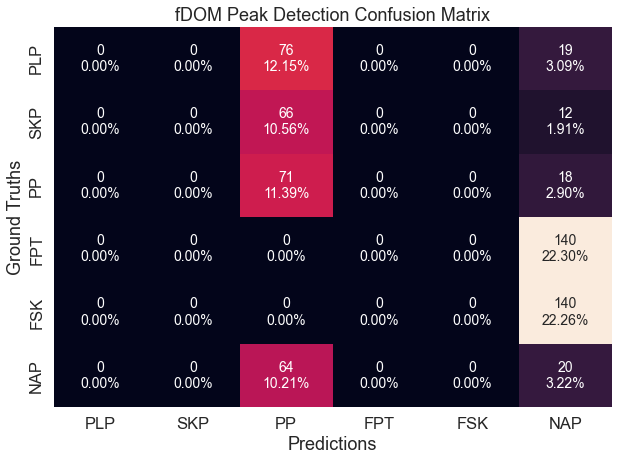

In [30]:
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_test_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_test_metrics))

for split in accumulated_best_params.keys():
    print(f"\nParams from split {split}:")
    for peak in accumulated_best_params[split].keys():
        print(f"\nFor peak type {peak}:")

        for param in accumulated_best_params[split][peak].keys():
            print(f"{param}, value: {accumulated_best_params[split][peak][param]}")

# print("Training time: ", overall_end_time - overall_start)

mean_cfmx = np.zeros((len(DATA_LABELS), len(DATA_LABELS)))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]

mean_cfmx = mean_cfmx / len(accumulated_cfmxs)

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Confusion Matrix")

sn.set(font_scale=1.5)

group_counts = ["{0:0.0f}\n".format(value) for value in mean_cfmx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in mean_cfmx.flatten()/np.sum(mean_cfmx)]

print(group_counts)
print(group_percentages)

box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(mean_cfmx.shape[0],mean_cfmx.shape[1])

sn.heatmap(
    mean_cfmx.astype("float"),
    annot=box_labels,
    xticklabels=DATA_LABELS,
    yticklabels=DATA_LABELS,
    fmt="",
    cbar=False,
    annot_kws ={"size": 14},
)

plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()


In [ ]:
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/fdom/best_params.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_best_params, pck_file)
    pck_file.close()

# Pickle test results
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/fdom/test_results.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle test metrics
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/fdom/test_metrics.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()


### Statistics from individual classifiers


In [ ]:
# print accuracies
print("PLP CLASSIFIER INFO:")
print("ACC: " + str(plp_classifer.best_acc))
print("f1: " + str(plp_classifer.best_f1_score))
print("\n")

print("SKP CLASSIFIER INFO:")
print("ACC: " + str(skp_classifier.best_acc))
print("f1: " + str(skp_classifier.best_f1_score))
print("\n")

print("PP CLASSIFIER INFO:")
print("ACC: " + str(pp_classifier.best_acc))
print("f1: " + str(pp_classifier.best_f1_score))
print("\n")

print("FPT CLASSIFIER INFO:")
print("ACC: " + str(fpt_classifier.best_acc))
print("f1: " + str(fpt_classifier.best_f1_score))
print("\n")

print("FSK CLASSIFIER INFO:")
print("ACC: " + str(fsk_classifier.best_acc))
print("f1: " + str(fsk_classifier.best_f1_score))
print("\n")


PLP CLASSIFIER INFO:
ACC: 0.5867249271743653
f1: 0.4201438848920863


SKP CLASSIFIER INFO:
ACC: 0
f1: 0


PP CLASSIFIER INFO:
ACC: 0.5902413649604661
f1: 0.6020066889632107


FPT CLASSIFIER INFO:
ACC: 0
f1: 0


FSK CLASSIFIER INFO:
ACC: 0
f1: 0


